In [1]:
%matplotlib inline


`Learn the Basics <intro.html>`_ ||
**Quickstart** ||
`Tensors <tensorqs_tutorial.html>`_ ||
`Datasets & DataLoaders <data_tutorial.html>`_ ||
`Transforms <transforms_tutorial.html>`_ ||
`Build Model <buildmodel_tutorial.html>`_ ||
`Autograd <autogradqs_tutorial.html>`_ ||
`Optimization <optimization_tutorial.html>`_ ||
`Save & Load Model <saveloadrun_tutorial.html>`_

Quickstart
===================
This section runs through the API for common tasks in machine learning. Refer to the links in each section to dive deeper.

Working with data
-----------------
PyTorch has two `primitives to work with data <https://pytorch.org/docs/stable/data.html>`_:
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``.




In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import torch.nn.functional as F


PyTorch offers domain-specific libraries such as `TorchText <https://pytorch.org/text/stable/index.html>`_,
`TorchVision <https://pytorch.org/vision/stable/index.html>`_, and `TorchAudio <https://pytorch.org/audio/stable/index.html>`_,
all of which include datasets. For this tutorial, we  will be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like
CIFAR, COCO (`full list here <https://pytorch.org/vision/stable/datasets.html>`_). In this tutorial, we
use the FashionMNIST dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and
``target_transform`` to modify the samples and labels respectively.



In [3]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.



In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break


Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


Read more about `loading data in PyTorch <data_tutorial.html>`_.




--------------




Creating Models
------------------
To define a neural network in PyTorch, we create a class that inherits
from `nn.Module <https://pytorch.org/docs/stable/generated/torch.nn.Module.html>`_. We define the layers of the network
in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate
operations in the neural network, we move it to the GPU if available.



Read more about `building neural networks in PyTorch <buildmodel_tutorial.html>`_.




--------------




In [5]:
import torch
print(torch.__version__)
# define the network
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class DLRANet(nn.Module):
    weights_K:list[torch.Tensor]  # n1 x r
    weights_Lt:list[torch.Tensor] # n2 x r
    weights_S:list[torch.Tensor]  # r x r
    aux_U:list[torch.Tensor]      # n1 x r
    aux_Unp1:list[torch.Tensor]   # n1 x r
    aux_Vt:list[torch.Tensor]     # r x n2
    aux_Vtnp1:list[torch.Tensor]  # r x n2
    aux_N:list[torch.Tensor]      # r x r
    aux_M:list[torch.Tensor]      # r x r
    biases:list[torch.Tensor]     # n2
    num_layers:int 
    layer_width:int
    
    def __init__(self,input_dim:int,output_dim:int,layer_width:int,num_layers:int,low_rank:int=10):
        self.num_layers = num_layers
        self.layer_width = layer_width
        # weight initialization
        W = torch.rand(input_dim,layer_width)
        W = W/torch.norm(W)
        #print(W.size())
        u, s, v = torch.svd(W)
        #print(W)
        #print(torch.mm(u,torch.mm(torch.diag(s),torch.transpose(v,0,1))))
        #print(torch.mm(torch.narrow(u, 1, 0, low_rank),torch.mm(torch.narrow(torch.narrow(torch.diag(s), 0, 0, low_rank) , 1, 0, low_rank),torch.narrow(torch.transpose(v,0,1), 0, 0, low_rank))))
        #print(torch.mm(torch.narrow(u, 1, 0, low_rank),torch.mm(torch.narrow(torch.narrow(torch.diag(s), 0, 0, low_rank) , 1, 0, low_rank),torch.narrow(torch.transpose(v,0,1), 0, 0, low_rank)))-W)
        #print(u.size())
        #print(s.size())
        #print(v.size())
        #t = torch.narrow(torch.narrow(torch.diag(s), 0, 0, low_rank) , 1, 0, low_rank)
        #print(t)
        vt=torch.transpose(v,0,1)
        low_rank_input = min(input_dim,low_rank)
        self.weights_K:list[torch.Tensor] = [torch.rand(input_dim,low_rank_input)]    # gets overwritten in K-step
        self.weights_Lt:list[torch.Tensor] = [torch.rand(layer_width,low_rank_input)] # gets overwritten in L-step
        self.weights_S:list[torch.Tensor] = [torch.narrow(torch.narrow(torch.diag(s), 0, 0, low_rank_input) , 1, 0, low_rank_input)]       # narrow to rxr
        self.aux_U:list[torch.Tensor] = [torch.narrow(u, 1, 0, low_rank_input)]      # narrow to n2xr
        self.aux_Unp1:list[torch.Tensor] = [torch.rand(input_dim,low_rank_input)]     # gets overwritten 
        self.aux_Vt:list[torch.Tensor] = [torch.narrow(vt, 0, 0, low_rank_input)]    # narrow to rxn1
        self.aux_Vtnp1:list[torch.Tensor] = [torch.rand(low_rank_input,layer_width)]   # gets overwritten 
        self.aux_N:list[torch.Tensor] = [torch.rand(low_rank_input,low_rank_input)]  # gets overwritten 
        self.aux_M:list[torch.Tensor] = [torch.rand(low_rank_input,low_rank_input)]  # gets overwritten 
        self.biases:list[torch.Tensor] = [torch.rand(layer_width)]       
        for i in range(1,num_layers-1):
            # weight initialization
            self.W = torch.rand(layer_width,layer_width)
            self.W = self.W/torch.norm(self.W)
            u, s, v = torch.svd(self.W)
            vt=torch.transpose(v,0,1)
            self.weights_K.append(torch.rand(layer_width,low_rank, requires_grad=True))
            self.weights_Lt.append(torch.rand(layer_width,low_rank, requires_grad=True))
            self.weights_S.append(torch.narrow(torch.narrow(torch.diag(s), 0, 0, low_rank) , 1, 0, low_rank))
            self.aux_U.append(torch.narrow(u, 1, 0, low_rank))
            self.aux_Unp1.append(torch.rand(layer_width,low_rank, requires_grad=False))
            self.aux_Vt.append(torch.narrow(vt, 0, 0, low_rank))
            self.aux_Vtnp1.append(torch.rand(low_rank,layer_width, requires_grad=False))
            self.aux_N.append(torch.rand(low_rank,low_rank, requires_grad=False))
            self.aux_M.append(torch.rand(low_rank,low_rank, requires_grad=False))
            self.biases.append(torch.rand(layer_width, requires_grad=True))
        W = torch.rand(layer_width,output_dim)
        W = W/torch.norm(W)
        u, s, v = torch.svd(W)
        vt=torch.transpose(v,0,1)
        low_rank_output = min(output_dim,low_rank)
        self.weights_K.append(torch.rand(layer_width,low_rank_output, requires_grad=True))
        self.weights_Lt.append(torch.rand(output_dim,low_rank_output, requires_grad=True))
        self.weights_S.append(torch.narrow(torch.narrow(torch.diag(s), 0, 0, low_rank_output) , 1, 0, low_rank_output))
        self.aux_U.append(torch.narrow(u, 1, 0, low_rank_output))
        self.aux_Unp1.append(torch.rand(layer_width,low_rank_output, requires_grad=False))
        self.aux_Vt.append(torch.narrow(vt, 0, 0, low_rank_output))
        self.aux_Vtnp1.append(torch.rand(low_rank_output,output_dim, requires_grad=False))
        self.aux_N.append(torch.rand(low_rank_output,low_rank, requires_grad=False))
        self.aux_M.append(torch.rand(low_rank_output,low_rank, requires_grad=False))
        self.biases.append(torch.rand(output_dim, requires_grad=True))

        with torch.no_grad():
            for i in range(0,self.num_layers):
                # mark for auto differentiation tape
                self.weights_K[i].requires_grad = True
                self.weights_Lt[i].requires_grad = True
                self.weights_S[i].requires_grad = True
                self.aux_U[i].requires_grad = False
                self.aux_Vt[i].requires_grad = False
                self.aux_N[i].requires_grad = False
                self.aux_M[i].requires_grad = False
                self.biases[i].requires_grad = True
        return None
    
    def K_step_forward(self,input_tensor:torch.Tensor)->torch.Tensor:
        # K-step of DRLA (forward pass)
        # prepare  K 
        with torch.no_grad():
            for i in range(0,self.num_layers):
                # a) update K
                self.weights_K[i] = torch.matmul(self.aux_U[i],self.weights_S[i])
                self.weights_K[i].requires_grad = True
        z = input_tensor
        # pass forward
        for i in range(0,self.num_layers-1):
            #z = f(xW+b) = f(xKV + b)
            z = F.relu(torch.matmul(z,torch.matmul(self.weights_K[i],self.aux_Vt[i])))

        return F.log_softmax(torch.matmul(z,torch.matmul(self.weights_K[self.num_layers-1],self.aux_Vt[self.num_layers-1])),-1)
    
    def K_step_update(self,stepsize:float=1e-3):
        # K-step of DRLA (update)
        with torch.no_grad():
            for i in range(0,self.num_layers):
                # gradient update
                self.weights_K[i]=self.weights_K[i]- stepsize* self.weights_K[i].grad
                self.weights_K[i].requires_grad = True
                # Create U
                self.aux_Unp1[i],_ = torch.qr(self.weights_K[i])
                #print(self.weights_K[i].size())
                #print(t.size())
                #print("unp1")
                #print(self.aux_Unp1[i].size())
                #print("U")
                #print(self.aux_U[i].size())
                #print("prod")
                #tmp = torch.matmul(torch.transpose(self.aux_Unp1[i], 0, 1),self.aux_U[i])
                #print(tmp.size())
                #print("____")
                # Create N
                self.aux_N[i] = torch.matmul(torch.transpose(self.aux_Unp1[i], 0, 1),self.aux_U[i])
        return None
    
    def L_step_forward(self,input_tensor:torch.Tensor)->torch.Tensor:
        # L-step of DLRA (forward)
        # prepare  L 
        with torch.no_grad():
            for i in range(0,self.num_layers):
                # a) update L
                self.weights_Lt[i] = torch.matmul(self.weights_S[i],self.aux_Vt[i]) # L-transpose 
                self.weights_Lt[i].requires_grad = True
        z = input_tensor
        # pass forward
        for i in range(0,self.num_layers-1):
            #z = f(xW+b) = f(xUL + b)
            z = F.relu(torch.matmul(z,torch.matmul(self.aux_U[i],self.weights_Lt[i])))
        return F.log_softmax(torch.matmul(z,torch.matmul(self.aux_U[self.num_layers-1],self.weights_Lt[self.num_layers-1])),-1) 
     
    def L_step_update(self,stepsize:float=1e-3):
        # L-step of DRLA (update)
        with torch.no_grad():
            for i in range(0,self.num_layers):
                # gradient update
                self.weights_Lt[i]=self.weights_Lt[i]- stepsize* self.weights_Lt[i].grad
                self.weights_Lt[i].requires_grad = True
                # Create V_np1
                self.aux_Vtnp1[i], _ = torch.qr(torch.transpose(self.weights_Lt[i], 0, 1))
                self.aux_Vtnp1[i] = torch.transpose(self.aux_Vtnp1[i], 0, 1)
                # Create N
                #print("S")
                #print(self.weights_S[i].size())
                #print("V")
                #print(self.aux_Vt[i].size())
                #print("L")
                #print(self.weighweights_Ltts_L[i].size())
                #print("Vnp1")
                #print(self.aux_Vtnp1[i].size())
                #print("V")
                #print(self.aux_Vt[i].size())
                #print("prod")
                #tmp =  torch.matmul(self.aux_Vtnp1[i],torch.transpose(self.aux_Vt[i], 0, 1))
                #print(tmp.size())
                #print("____")
                self.aux_M[i] = torch.matmul(self.aux_Vtnp1[i],torch.transpose(self.aux_Vt[i], 0, 1)) #Vtnp1*V
                # Update U_np1
                #self.aux_U[i] = U_np1
        return None
    
    def S_step_forward(self,input_tensor:torch.Tensor)->torch.Tensor:
        # S-step of DLRA (forward)
        # prepare  S
        with torch.no_grad():
            for i in range(0,self.num_layers):
                # a) update S
                self.weights_S[i] = torch.matmul(torch.matmul(self.aux_N[i],self.weights_S[i]),torch.transpose(self.aux_M[i], 0, 1)) # S
                self.weights_S[i].requires_grad = True
        
        z = input_tensor
        # pass forward
        for i in range(0,self.num_layers-1):
            #z = f(xW+b) \approx f(xUnp1 S Vnp1^T + b)
            z = F.relu(torch.matmul(z,torch.matmul(self.aux_Unp1[i],torch.matmul(self.weights_S[i],self.aux_Vtnp1[i]))))
        #print(self.W.size())
        #print(self.W)
        #t = torch.matmul(self.aux_Unp1[self.num_layers-2],torch.matmul(self.weights_S[self.num_layers-2],self.aux_Vtnp1[self.num_layers-2]))
        #print(t.size())
        #print(t)
        #print("____")
        return F.log_softmax(torch.matmul(z,torch.matmul(self.aux_Unp1[self.num_layers-1],torch.matmul(self.weights_S[self.num_layers-1],self.aux_Vtnp1[self.num_layers-1]))),-1) 
     
    def S_step_update(self,stepsize:float=1e-3):
        # S-step of DRLA (update)
        with torch.no_grad():
            for i in range(0,self.num_layers):
                # gradient update
                self.weights_S[i]=self.weights_S[i]- stepsize* self.weights_S[i].grad
                self.weights_S[i].requires_grad = True
                # update U to Unp1 and V to Vnp1
                self.aux_U[i] = self.aux_Unp1[i]
                self.aux_Vt[i] = self.aux_Vtnp1[i]
        return None
    
    def clear_grads(self):
        #print("Clear Grads")
        for i in range(0,self.num_layers):
            if self.weights_K[i].grad is not None:
                self.weights_K[i].grad.data.zero_()
            if self.weights_Lt[i].grad is not None:
                self.weights_Lt[i].grad.data.zero_()
            if self.weights_S[i].grad is not None:
                self.weights_S[i].grad.data.zero_()
            if self.aux_U[i].grad is not None:
                self.aux_U[i].grad.data.zero_()
            if self.aux_Unp1[i].grad is not None:
                self.aux_Unp1[i].grad.data.zero_()
            if self.aux_Vt[i].grad is not None:
                self.aux_Vt[i].grad.data.zero_()
            if self.aux_Vtnp1[i].grad is not None:
                self.aux_Vtnp1[i].grad.data.zero_()
            if self.aux_N[i].grad is not None:
                self.aux_N[i].grad.data.zero_()
            if self.aux_M[i].grad is not None:
                self.aux_M[i].grad.data.zero_()
            if self.biases[i].grad is not None:
                self.biases[i].grad.data.zero_()
        return None
        
    def print_layer_size(self):
         for i in range(0,self.num_layers):
            print("layer "+ str(i))
            print("K")
            print(self.weights_K[i].size())
            print("Lt")
            print(self.weights_Lt[i].size())
            print("S")
            print(self.weights_S[i].size())
            print("U")
            print(self.aux_U[i].size())
            print("Unp1")
            print(self.aux_Unp1[i].size())
            print("Vt")
            print(self.aux_Vt[i].size())
            print("Vtnp1")
            print(self.aux_Vtnp1[i].size())
            print("N")
            print(self.aux_N[i].size())
            print("M")
            print(self.aux_M[i].size())
            print("b")
            print(self.biases[i].size())
    
    def print_layer_weights(self):
        for i in range(0,self.num_layers):
            print("layer "+ str(i))
            print("K")
            print(self.weights_K[i])
            print("L")
            print(self.weights_Lt[i])
            print("S")
            print(self.weights_S[i])
            print("U")
            print(self.aux_U[i])
            print("Unp1")
            print(self.aux_Unp1[i])
            print("Vt")
            print(self.aux_Vt[i])
            print("Vtnp1")
            print(self.aux_Vtnp1[i])
            print("N")
            print(self.aux_N[i])
            print("M")
            print(self.aux_M[i])
            print("b")
            print(self.biases[i])
        return None
    
    def print_weights_K(self):
        print("K")
        for i in range(0,self.num_layers):
            print("layer "+ str(i))
            print(self.weights_K[i])
            
    def print_weights_Lt(self):
        print("L")
        for i in range(0,self.num_layers):
            print("layer "+ str(i))
            print(self.weights_Lt[i])
            
    def print_weights_S(self):
        print("S")
        for i in range(0,self.num_layers):
            print("layer "+ str(i))
            print(self.weights_S[i])
    
    def print_aux_M(self):
        print("M")
        for i in range(0,self.num_layers):
            print("layer "+ str(i))
            print(self.aux_M[i])
    
    def print_aux_N(self):
        print("N")
        for i in range(0,self.num_layers):
            print("layer "+ str(i))
            print(self.aux_N[i])
    

1.7.1
Using cpu device


In [6]:
## some sanity checks 
test_net = DLRANet(input_dim=10,output_dim=10,layer_width=10,num_layers=3,low_rank=10)
#test_net.print_layer_size()
print("input")
x = torch.rand(5,10) # random flattened images
y = torch.randint(0,9,(5,)) #random labels
#print(x)
#print(x.size())
#print("labels")
#print(y.size())

input


In [7]:
print("layer size")
#test_net.print_layer_size()

layer size


In [8]:
print("layer weights")
#test_net.print_layer_weights()

layer weights


In [9]:
print("K_step")
out = test_net.K_step_forward(x)
print("output")
print(out.size())
loss = F.nll_loss(out, y)
print("loss")
print(loss.size())
print(loss)
loss.backward()
test_net.K_step_update(stepsize=1e-2)
test_net.clear_grads()

K_step
output
torch.Size([5, 10])
loss
torch.Size([])
tensor(2.3060, grad_fn=<NllLossBackward>)


In [10]:
print("L_step_forward")
out = test_net.L_step_forward(x)
print("output")
print(out.size())
loss = F.nll_loss(out, y)
print("loss")
print(loss.size())
print(loss)
loss.backward()
test_net.L_step_update(stepsize=1e-2)
test_net.clear_grads()

L_step_forward
output
torch.Size([5, 10])
loss
torch.Size([])
tensor(2.3060, grad_fn=<NllLossBackward>)


In [11]:
print("S_step_forward")
out = test_net.S_step_forward(x)
print("output")
print(out.size())
loss = F.nll_loss(out, y)
print("loss")
print(loss.size())
print(loss)
loss.backward()
test_net.S_step_update(stepsize=1e-2)
test_net.clear_grads()

S_step_forward
output
torch.Size([5, 10])
loss
torch.Size([])
tensor(2.3060, grad_fn=<NllLossBackward>)


# Define Network for MNIST

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
backpropagates the prediction error to adjust the model's parameters.



We also check the model's performance against the test dataset to ensure it is learning.



The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.



Read more about `Training your model <optimization_tutorial.html>`_.




--------------




In [12]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    #model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            x = nn.Flatten()(X)
            ## Only S-Step ##
            pred = model.S_step_forward(x)
            ## L-Step ##
            test_loss += F.nll_loss(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [13]:
def train(dataloader, model, loss_fn,curr_epoch):
    size = len(dataloader.dataset)
    #model.train()
    for batch, (X, y) in enumerate(dataloader):
        
        X, y = X.to(device), y.to(device)
        x = nn.Flatten()(X)
       
        # Compute prediction error
        
        ## K-Step ##
        #print("K-Step")
        out = model.K_step_forward(x)
        loss = F.nll_loss(out, y)
        #print(loss)
        loss.backward()
        model.K_step_update(stepsize=1e-2/(curr_epoch))
        #model.print_weights_K()
        model.clear_grads()
        
        ## L-Step ##
        #print("L-Step")
        out = model.L_step_forward(x)
        loss = F.nll_loss(out, y)
        #print(loss)
        loss.backward()
        model.L_step_update(stepsize=1e-2/(curr_epoch))
        #model.print_weights_Lt()
        model.clear_grads()
        
        ## S-Step ##
        #print("S-Step")
        out = model.S_step_forward(x)
        #model.print_weights_S()

        loss = F.nll_loss(out, y)
        #print(loss)
        loss.backward()
        #model.print_weights_S()
        #model.print_aux_M()
        #model.print_aux_N()
        model.S_step_update(stepsize=1e-2/(curr_epoch))
        model.clear_grads()
        

        #print(model.weights[1])
        #if batch % 100 == 0:
        #    loss, current = loss.item(), batch * len(X)
        #    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [14]:
## Define network
batch_size = 64
input_dim = 784
output_dim = 10
layer_width = 100
layer_num = 5
low_rank = 10
model = DLRANet(input_dim,output_dim,layer_width,layer_num,low_rank)
loss_fn =  torch.nn.functional.nll_loss


In [15]:
# check weight initializations
#model.print_layer_size()
#model.print_layer_weights()

In [16]:
epochs =100
for t in range(epochs):
    #model.print_layer_size()
    #model.print_layer_weights()
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn,t+1)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 9.8%, Avg loss: 2.253953 

Epoch 2
-------------------------------


KeyboardInterrupt: 

In [17]:
#torch.save(model.state_dict(), "model.pth")
#print("Saved PyTorch Model State to model.pth")

### Low Rank Toy Problem ###
1) Create Data

In [18]:
# Import libraries
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
# create custom dataset class
class CustomTextDataset(Dataset):
    def __init__(self, text, labels):
        self.labels = labels
        self.text = text

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.text[idx]
        sample = {"X_data": data, "Y_data": label}
        return sample

In [39]:
x = np.random.rand(6000,2)
y = np.linalg.norm(x,axis=1,keepdims=True)
x_data = list(x)
y_data = list(y)
print(x.shape)
print(y.shape)
# create Pandas DataFrame
text_labels_df = pd.DataFrame({'X_Values': x_data, 'Y_Values': y_data})

# define data set object
ToyDataset = CustomTextDataset(text_labels_df['X_Values'], text_labels_df['Y_Values'])

# Display image and label.
#print('\nFirst iteration of data set: ', next(iter(TD)), '\n')

# Print how many items are in the data set
#print('Length of data set: ', len(TD), '\n')

# Print entire data set
#print('Entire data set: ', list(DataLoader(TD)), '\n')

## test data

x = np.random.rand(1000,2)
y = np.linalg.norm(x,axis=1,keepdims=True)
x_data_test = list(x)
y_data_test = list(y)
#print(x_data)
#print(y_data)
# create Pandas DataFrame
text_labels_df = pd.DataFrame({'X_Values': x_data_test, 'Y_Values': y_data_test})

# define data set object
ToyDataset_Test = CustomTextDataset(text_labels_df['X_Values'], text_labels_df['Y_Values'])



(6000, 2)
(6000, 1)


In [40]:
# Create data loaders.
#print(training_data)
batch_size =10
train_dataloader = DataLoader(ToyDataset, batch_size=batch_size)
test_dataloader = DataLoader(ToyDataset_Test, batch_size=batch_size)

for batch, sample in enumerate(train_dataloader):
    print(batch)
    print(sample["X_data"])
    print(sample["Y_data"])


0
tensor([[0.6100, 0.4084],
        [0.1527, 0.0170],
        [0.9885, 0.9831],
        [0.1771, 0.3324],
        [0.3991, 0.1073],
        [0.3470, 0.8172],
        [0.3615, 0.8503],
        [0.4868, 0.5964],
        [0.5075, 0.7624],
        [0.7130, 0.5158]], dtype=torch.float64)
tensor([[0.7341],
        [0.1537],
        [1.3942],
        [0.3766],
        [0.4133],
        [0.8879],
        [0.9239],
        [0.7699],
        [0.9159],
        [0.8800]], dtype=torch.float64)
1
tensor([[0.7302, 0.6229],
        [0.7591, 0.1776],
        [0.9461, 0.7812],
        [0.4076, 0.6022],
        [0.1111, 0.0606],
        [0.8093, 0.5333],
        [0.7402, 0.1583],
        [0.3233, 0.6945],
        [0.3083, 0.4811],
        [0.3953, 0.8259]], dtype=torch.float64)
tensor([[0.9598],
        [0.7796],
        [1.2269],
        [0.7271],
        [0.1265],
        [0.9692],
        [0.7569],
        [0.7660],
        [0.5714],
        [0.9156]], dtype=torch.float64)
2
tensor([[0.2845, 0.6293],


183
tensor([[0.4298, 0.2990],
        [0.9606, 0.6954],
        [0.2310, 0.8899],
        [0.0653, 0.7439],
        [0.5183, 0.4589],
        [0.7936, 0.2172],
        [0.9083, 0.1349],
        [0.5983, 0.8589],
        [0.8236, 0.2099],
        [0.8000, 0.1090]], dtype=torch.float64)
tensor([[0.5236],
        [1.1859],
        [0.9194],
        [0.7468],
        [0.6922],
        [0.8228],
        [0.9182],
        [1.0468],
        [0.8499],
        [0.8074]], dtype=torch.float64)
184
tensor([[0.4901, 0.6360],
        [0.6483, 0.6038],
        [0.3320, 0.5571],
        [0.6475, 0.5156],
        [0.0100, 0.7695],
        [0.8921, 0.6030],
        [0.8768, 0.9598],
        [0.3891, 0.9751],
        [0.5193, 0.1009],
        [0.7813, 0.0895]], dtype=torch.float64)
tensor([[0.8030],
        [0.8859],
        [0.6485],
        [0.8277],
        [0.7696],
        [1.0768],
        [1.3000],
        [1.0499],
        [0.5290],
        [0.7865]], dtype=torch.float64)
185
tensor([[0.1488, 0.7

412
tensor([[0.2532, 0.2983],
        [0.3242, 0.6005],
        [0.1113, 0.5698],
        [0.0983, 0.7111],
        [0.4188, 0.4723],
        [0.9799, 0.5010],
        [0.9617, 0.2430],
        [0.6197, 0.7083],
        [0.8348, 0.3281],
        [0.1471, 0.0242]], dtype=torch.float64)
tensor([[0.3913],
        [0.6824],
        [0.5805],
        [0.7179],
        [0.6312],
        [1.1005],
        [0.9919],
        [0.9412],
        [0.8969],
        [0.1491]], dtype=torch.float64)
413
tensor([[0.4126, 0.8769],
        [0.7690, 0.0546],
        [0.7179, 0.5131],
        [0.1967, 0.6511],
        [0.5853, 0.6258],
        [0.1898, 0.3094],
        [0.7251, 0.7590],
        [0.1794, 0.8684],
        [0.2318, 0.8003],
        [0.7310, 0.8231]], dtype=torch.float64)
tensor([[0.9691],
        [0.7710],
        [0.8824],
        [0.6802],
        [0.8568],
        [0.3630],
        [1.0497],
        [0.8867],
        [0.8331],
        [1.1008]], dtype=torch.float64)
414
tensor([[0.2927, 0.7

In [50]:
# create network
import torch
print(torch.__version__)
# define the network
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class DLRANet_Regression(nn.Module):
    weights_K:list[torch.Tensor]  # n1 x r
    weights_Lt:list[torch.Tensor] # n2 x r
    weights_S:list[torch.Tensor]  # r x r
    aux_U:list[torch.Tensor]      # n1 x r
    aux_Unp1:list[torch.Tensor]   # n1 x r
    aux_Vt:list[torch.Tensor]     # r x n2
    aux_Vtnp1:list[torch.Tensor]  # r x n2
    aux_N:list[torch.Tensor]      # r x r
    aux_M:list[torch.Tensor]      # r x r
    biases:list[torch.Tensor]     # n2
    num_layers:int 
    layer_width:int
    
    def __init__(self,input_dim:int,output_dim:int,layer_width:int,num_layers:int,low_rank:int=10):
        self.num_layers = num_layers
        self.layer_width = layer_width
        # weight initialization
        W = torch.rand(input_dim,layer_width)
        W = W/torch.norm(W)
        #print(W.size())
        u, s, v = torch.svd(W)
        #print(W)
        #print(torch.mm(u,torch.mm(torch.diag(s),torch.transpose(v,0,1))))
        #print(torch.mm(torch.narrow(u, 1, 0, low_rank),torch.mm(torch.narrow(torch.narrow(torch.diag(s), 0, 0, low_rank) , 1, 0, low_rank),torch.narrow(torch.transpose(v,0,1), 0, 0, low_rank))))
        #print(torch.mm(torch.narrow(u, 1, 0, low_rank),torch.mm(torch.narrow(torch.narrow(torch.diag(s), 0, 0, low_rank) , 1, 0, low_rank),torch.narrow(torch.transpose(v,0,1), 0, 0, low_rank)))-W)
        #print(u.size())
        #print(s.size())
        #print(v.size())
        #t = torch.narrow(torch.narrow(torch.diag(s), 0, 0, low_rank) , 1, 0, low_rank)
        #print(t)
        vt=torch.transpose(v,0,1)
        low_rank_input = min(input_dim,low_rank)
        self.weights_K:list[torch.Tensor] = [torch.rand(input_dim,low_rank_input)]    # gets overwritten in K-step
        self.weights_Lt:list[torch.Tensor] = [torch.rand(layer_width,low_rank_input)] # gets overwritten in L-step
        self.weights_S:list[torch.Tensor] = [torch.narrow(torch.narrow(torch.diag(s), 0, 0, low_rank_input) , 1, 0, low_rank_input)]       # narrow to rxr
        self.aux_U:list[torch.Tensor] = [torch.narrow(u, 1, 0, low_rank_input)]      # narrow to n2xr
        self.aux_Unp1:list[torch.Tensor] = [torch.rand(input_dim,low_rank_input)]     # gets overwritten 
        self.aux_Vt:list[torch.Tensor] = [torch.narrow(vt, 0, 0, low_rank_input)]    # narrow to rxn1
        self.aux_Vtnp1:list[torch.Tensor] = [torch.rand(low_rank_input,layer_width)]   # gets overwritten 
        self.aux_N:list[torch.Tensor] = [torch.rand(low_rank_input,low_rank_input)]  # gets overwritten 
        self.aux_M:list[torch.Tensor] = [torch.rand(low_rank_input,low_rank_input)]  # gets overwritten 
        self.biases:list[torch.Tensor] = [torch.rand(layer_width)]       
        for i in range(1,num_layers-1):
            # weight initialization
            self.W = torch.rand(layer_width,layer_width)
            self.W = self.W/torch.norm(self.W)
            u, s, v = torch.svd(self.W)
            vt=torch.transpose(v,0,1)
            self.weights_K.append(torch.rand(layer_width,low_rank, requires_grad=True))
            self.weights_Lt.append(torch.rand(layer_width,low_rank, requires_grad=True))
            self.weights_S.append(torch.narrow(torch.narrow(torch.diag(s), 0, 0, low_rank) , 1, 0, low_rank))
            self.aux_U.append(torch.narrow(u, 1, 0, low_rank))
            self.aux_Unp1.append(torch.rand(layer_width,low_rank, requires_grad=False))
            self.aux_Vt.append(torch.narrow(vt, 0, 0, low_rank))
            self.aux_Vtnp1.append(torch.rand(low_rank,layer_width, requires_grad=False))
            self.aux_N.append(torch.rand(low_rank,low_rank, requires_grad=False))
            self.aux_M.append(torch.rand(low_rank,low_rank, requires_grad=False))
            self.biases.append(torch.rand(layer_width, requires_grad=True))
        W = torch.rand(layer_width,output_dim)
        W = W/torch.norm(W)
        u, s, v = torch.svd(W)
        vt=torch.transpose(v,0,1)
        low_rank_output = min(output_dim,low_rank)
        self.weights_K.append(torch.rand(layer_width,low_rank_output, requires_grad=True))
        self.weights_Lt.append(torch.rand(output_dim,low_rank_output, requires_grad=True))
        self.weights_S.append(torch.narrow(torch.narrow(torch.diag(s), 0, 0, low_rank_output) , 1, 0, low_rank_output))
        self.aux_U.append(torch.narrow(u, 1, 0, low_rank_output))
        self.aux_Unp1.append(torch.rand(layer_width,low_rank_output, requires_grad=False))
        self.aux_Vt.append(torch.narrow(vt, 0, 0, low_rank_output))
        self.aux_Vtnp1.append(torch.rand(low_rank_output,output_dim, requires_grad=False))
        self.aux_N.append(torch.rand(low_rank_output,low_rank, requires_grad=False))
        self.aux_M.append(torch.rand(low_rank_output,low_rank, requires_grad=False))
        self.biases.append(torch.rand(output_dim, requires_grad=True))

        with torch.no_grad():
            for i in range(0,self.num_layers):
                # mark for auto differentiation tape
                self.weights_K[i].requires_grad = True
                self.weights_Lt[i].requires_grad = True
                self.weights_S[i].requires_grad = True
                self.aux_U[i].requires_grad = False
                self.aux_Vt[i].requires_grad = False
                self.aux_N[i].requires_grad = False
                self.aux_M[i].requires_grad = False
                self.biases[i].requires_grad = True
        return None
    
    def K_step_forward(self,input_tensor:torch.Tensor)->torch.Tensor:
        # K-step of DRLA (forward pass)
        # prepare  K 
        with torch.no_grad():
            for i in range(0,self.num_layers):
                # a) update K
                self.weights_K[i] = torch.matmul(self.aux_U[i],self.weights_S[i])
                self.weights_K[i].requires_grad = True
        z = input_tensor
        # pass forward
        for i in range(0,self.num_layers-1):
            #z = f(xW+b) = f(xKV + b)
            z = F.relu(torch.matmul(z,torch.matmul(self.weights_K[i],self.aux_Vt[i])))

        return F.relu(torch.matmul(z,torch.matmul(self.weights_K[self.num_layers-1],self.aux_Vt[self.num_layers-1])))
    
    def K_step_update(self,stepsize:float=1e-3):
        # K-step of DRLA (update)
        with torch.no_grad():
            for i in range(0,self.num_layers):
                # gradient update
                self.weights_K[i]=self.weights_K[i]- stepsize* self.weights_K[i].grad
                self.weights_K[i].requires_grad = True
                # Create U
                self.aux_Unp1[i],_ = torch.qr(self.weights_K[i])
                #print(self.weights_K[i].size())
                #print(t.size())
                #print("unp1")
                #print(self.aux_Unp1[i].size())
                #print("U")
                #print(self.aux_U[i].size())
                #print("prod")
                #tmp = torch.matmul(torch.transpose(self.aux_Unp1[i], 0, 1),self.aux_U[i])
                #print(tmp.size())
                #print("____")
                # Create N
                self.aux_N[i] = torch.matmul(torch.transpose(self.aux_Unp1[i], 0, 1),self.aux_U[i])
        return None
    
    def L_step_forward(self,input_tensor:torch.Tensor)->torch.Tensor:
        # L-step of DLRA (forward)
        # prepare  L 
        with torch.no_grad():
            for i in range(0,self.num_layers):
                # a) update L
                self.weights_Lt[i] = torch.matmul(self.weights_S[i],self.aux_Vt[i]) # L-transpose 
                self.weights_Lt[i].requires_grad = True
        z = input_tensor
        # pass forward
        for i in range(0,self.num_layers-1):
            #z = f(xW+b) = f(xUL + b)
            z = F.relu(torch.matmul(z,torch.matmul(self.aux_U[i],self.weights_Lt[i])))
        return F.relu(torch.matmul(z,torch.matmul(self.aux_U[self.num_layers-1],self.weights_Lt[self.num_layers-1])))
     
    def L_step_update(self,stepsize:float=1e-3):
        # L-step of DRLA (update)
        with torch.no_grad():
            for i in range(0,self.num_layers):
                # gradient update
                self.weights_Lt[i]=self.weights_Lt[i]- stepsize* self.weights_Lt[i].grad
                self.weights_Lt[i].requires_grad = True
                # Create V_np1
                self.aux_Vtnp1[i], _ = torch.qr(torch.transpose(self.weights_Lt[i], 0, 1))
                self.aux_Vtnp1[i] = torch.transpose(self.aux_Vtnp1[i], 0, 1)
                # Create N
                #print("S")
                #print(self.weights_S[i].size())
                #print("V")
                #print(self.aux_Vt[i].size())
                #print("L")
                #print(self.weighweights_Ltts_L[i].size())
                #print("Vnp1")
                #print(self.aux_Vtnp1[i].size())
                #print("V")
                #print(self.aux_Vt[i].size())
                #print("prod")
                #tmp =  torch.matmul(self.aux_Vtnp1[i],torch.transpose(self.aux_Vt[i], 0, 1))
                #print(tmp.size())
                #print("____")
                self.aux_M[i] = torch.matmul(self.aux_Vtnp1[i],torch.transpose(self.aux_Vt[i], 0, 1)) #Vtnp1*V
                # Update U_np1
                #self.aux_U[i] = U_np1
        return None
    
    def S_step_forward(self,input_tensor:torch.Tensor)->torch.Tensor:
        # S-step of DLRA (forward)
        # prepare  S
        with torch.no_grad():
            for i in range(0,self.num_layers):
                # a) update S
                self.weights_S[i] = torch.matmul(torch.matmul(self.aux_N[i],self.weights_S[i]),torch.transpose(self.aux_M[i], 0, 1)) # S
                self.weights_S[i].requires_grad = True
        
        z = input_tensor
        # pass forward
        for i in range(0,self.num_layers-1):
            #z = f(xW+b) \approx f(xUnp1 S Vnp1^T + b)
            z = F.relu(torch.matmul(z,torch.matmul(self.aux_Unp1[i],torch.matmul(self.weights_S[i],self.aux_Vtnp1[i]))))
        #print(self.W.size())
        #print(self.W)
        #t = torch.matmul(self.aux_Unp1[self.num_layers-2],torch.matmul(self.weights_S[self.num_layers-2],self.aux_Vtnp1[self.num_layers-2]))
        #print(t.size())
        #print(t)
        #print("____")
        return F.relu(torch.matmul(z,torch.matmul(self.aux_Unp1[self.num_layers-1],torch.matmul(self.weights_S[self.num_layers-1],self.aux_Vtnp1[self.num_layers-1])))) 
     
    def S_step_update(self,stepsize:float=1e-3):
        # S-step of DRLA (update)
        with torch.no_grad():
            for i in range(0,self.num_layers):
                # gradient update
                self.weights_S[i]=self.weights_S[i]- stepsize* self.weights_S[i].grad
                self.weights_S[i].requires_grad = True
                # update U to Unp1 and V to Vnp1
                self.aux_U[i] = self.aux_Unp1[i]
                self.aux_Vt[i] = self.aux_Vtnp1[i]
        return None
    
    def clear_grads(self):
        #print("Clear Grads")
        for i in range(0,self.num_layers):
            if self.weights_K[i].grad is not None:
                self.weights_K[i].grad.data.zero_()
            if self.weights_Lt[i].grad is not None:
                self.weights_Lt[i].grad.data.zero_()
            if self.weights_S[i].grad is not None:
                self.weights_S[i].grad.data.zero_()
            if self.aux_U[i].grad is not None:
                self.aux_U[i].grad.data.zero_()
            if self.aux_Unp1[i].grad is not None:
                self.aux_Unp1[i].grad.data.zero_()
            if self.aux_Vt[i].grad is not None:
                self.aux_Vt[i].grad.data.zero_()
            if self.aux_Vtnp1[i].grad is not None:
                self.aux_Vtnp1[i].grad.data.zero_()
            if self.aux_N[i].grad is not None:
                self.aux_N[i].grad.data.zero_()
            if self.aux_M[i].grad is not None:
                self.aux_M[i].grad.data.zero_()
            if self.biases[i].grad is not None:
                self.biases[i].grad.data.zero_()
        return None
        
    def print_layer_size(self):
         for i in range(0,self.num_layers):
            print("layer "+ str(i))
            print("K")
            print(self.weights_K[i].size())
            print("Lt")
            print(self.weights_Lt[i].size())
            print("S")
            print(self.weights_S[i].size())
            print("U")
            print(self.aux_U[i].size())
            print("Unp1")
            print(self.aux_Unp1[i].size())
            print("Vt")
            print(self.aux_Vt[i].size())
            print("Vtnp1")
            print(self.aux_Vtnp1[i].size())
            print("N")
            print(self.aux_N[i].size())
            print("M")
            print(self.aux_M[i].size())
            print("b")
            print(self.biases[i].size())
    
    def print_layer_weights(self):
        for i in range(0,self.num_layers):
            print("layer "+ str(i))
            print("K")
            print(self.weights_K[i])
            print("L")
            print(self.weights_Lt[i])
            print("S")
            print(self.weights_S[i])
            print("U")
            print(self.aux_U[i])
            print("Unp1")
            print(self.aux_Unp1[i])
            print("Vt")
            print(self.aux_Vt[i])
            print("Vtnp1")
            print(self.aux_Vtnp1[i])
            print("N")
            print(self.aux_N[i])
            print("M")
            print(self.aux_M[i])
            print("b")
            print(self.biases[i])
        return None
    
    def print_weights_K(self):
        print("K")
        for i in range(0,self.num_layers):
            print("layer "+ str(i))
            print(self.weights_K[i])
            
    def print_weights_Lt(self):
        print("L")
        for i in range(0,self.num_layers):
            print("layer "+ str(i))
            print(self.weights_Lt[i])
            
    def print_weights_S(self):
        print("S")
        for i in range(0,self.num_layers):
            print("layer "+ str(i))
            print(self.weights_S[i])
    
    def print_aux_M(self):
        print("M")
        for i in range(0,self.num_layers):
            print("layer "+ str(i))
            print(self.aux_M[i])
    
    def print_aux_N(self):
        print("N")
        for i in range(0,self.num_layers):
            print("layer "+ str(i))
            print(self.aux_N[i])
    

1.7.1
Using cpu device


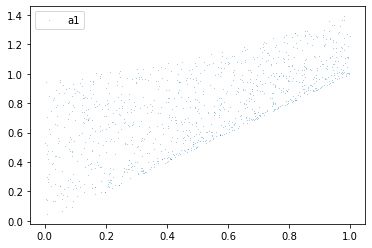

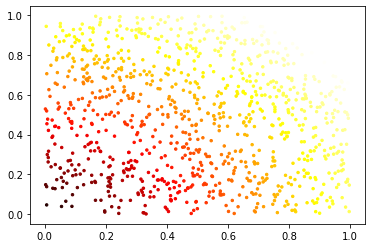

In [51]:
import matplotlib.pyplot as plt
from matplotlib import cm

plt.plot(x[:,0],y,'*', markersize=0.1)
plt.legend(['a1','a2','a3'])
plt.show()
out = plt.scatter(x[:,0], x[:,1], s=6, c=y, cmap=cm.hot, vmin=0, vmax=1.2)
plt.show()



In [68]:
## Define network
batch_size = 128
input_dim = 2
output_dim = 1
layer_width = 10
layer_num = 3
low_rank = 10
model = DLRANet_Regression(input_dim,output_dim,layer_width,layer_num,low_rank)
loss_fn =  torch.nn.functional.mse_loss


In [69]:
def test_toy(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    #model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X=sample["X_data"]
            Y=sample["Y_data"]
        
            x, y = X.to(device).float(), Y.to(device).float()
            ## Only S-Step ##
            pred = model.S_step_forward(x)
            ## L-Step ##
            test_loss += loss_fn(pred, y).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    print(f"Test Error:%, Avg loss: {test_loss:>8f} \n")

In [70]:
stepsize=1e-2

def train_toy(dataloader, model, loss_fn,curr_epoch):
    size = len(dataloader.dataset)
    #model.train()
    for batch, sample in enumerate(dataloader):
        
        X=sample["X_data"]
        Y=sample["Y_data"]
        
        x, y = X.to(device).float(), Y.to(device).float()
        #print(x.size())
        #print(y.size())
        #x = nn.Flatten()(X)
       
        # Compute prediction error
        
        ## K-Step ##
        #print("K-Step")
        out = model.K_step_forward(x)
        #print(out.size())
        #print("___")
        loss = loss_fn(out, y)
        #print(loss)
        loss.backward()
        model.K_step_update(stepsize=stepsize)
        #model.print_weights_K()
        model.clear_grads()
        
        ## L-Step ##
        #print("L-Step")
        out = model.L_step_forward(x)
        loss = loss_fn(out, y)
        #print(loss)
        loss.backward()
        model.L_step_update(stepsize=stepsize)
        #model.print_weights_Lt()
        model.clear_grads()
        
        ## S-Step ##
        #print("S-Step")
        out = model.S_step_forward(x)
        #model.print_weights_S()
        loss = loss_fn(out, y)
        #print(loss)
        loss.backward()
        #model.print_weights_S()
        #model.print_aux_M()
        #model.print_aux_N()
        model.S_step_update(stepsize=stepsize)
        model.clear_grads()
        

        #print(model.weights[1])
        #if batch % 100 == 0:
        #    loss, current = loss.item(), batch * len(X)
        #    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [71]:
epochs =100
for t in range(epochs):
    #model.print_layer_size()
    #model.print_layer_weights()
    print(f"Epoch {t+1}\n-------------------------------")
    train_toy(train_dataloader, model, loss_fn,t+1)
    test_toy(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Test Error:%, Avg loss: 0.003047 

Epoch 2
-------------------------------
Test Error:%, Avg loss: 0.003122 

Epoch 3
-------------------------------
Test Error:%, Avg loss: 0.003148 

Epoch 4
-------------------------------
Test Error:%, Avg loss: 0.003155 

Epoch 5
-------------------------------
Test Error:%, Avg loss: 0.003155 

Epoch 6
-------------------------------
Test Error:%, Avg loss: 0.003154 

Epoch 7
-------------------------------
Test Error:%, Avg loss: 0.003151 

Epoch 8
-------------------------------
Test Error:%, Avg loss: 0.003149 

Epoch 9
-------------------------------
Test Error:%, Avg loss: 0.003147 

Epoch 10
-------------------------------
Test Error:%, Avg loss: 0.003144 

Epoch 11
-------------------------------
Test Error:%, Avg loss: 0.003143 

Epoch 12
-------------------------------
Test Error:%, Avg loss: 0.003140 

Epoch 13
-------------------------------
Test Error:%, Avg loss: 0.003138 

Epoch 14
------------

In [ ]:
# test the network
x = np.random.rand(6000,2)
y = np.linalg.norm(x,axis=1,keepdims=True)

pred = model.S_step_forward(x)

In [ ]:
plt.plot(x[:,0],y,'*', markersize=0.1)
plt.legend(['a1','a2','a3'])
plt.show()
out = plt.scatter(x[:,0], x[:,1], s=6, c=y, cmap=cm.hot, vmin=0, vmax=1.2)
plt.show()

(10, 10)
(10, 10)
(10, 10)
[[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]]
[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
 [0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6]
 [0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7]
 [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]]


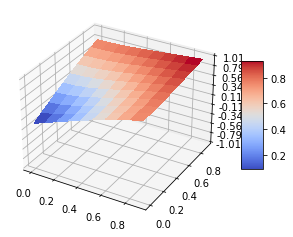

In [67]:

from matplotlib.ticker import LinearLocator

X = np.arange(0, 1, 0.1)
Y = np.arange(0, 1, 0.1)
X, Y = np.meshgrid(X, Y)
print(X.shape)
print(Y.shape)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)
print(Z.shape)
print(X)
print(Y)
# Plot the surface.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()